<a href="https://colab.research.google.com/github/DeepaliJosh/Women-Clothing-Sentiment-Analysis/blob/main/E_Commerece_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sentiment analysis for women's clothing e-commerce reviews

**Importing the required Libraries**

In [6]:
!pip install chart-studio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

import tensorflow as tf
from tensorflow import keras

import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

# sklearn, for preprocessing & scoring
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score, precision_score, average_precision_score, roc_curve, roc_auc_score, auc

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Reading the data**

In [7]:
ecom_review= pd.read_csv("/content/Womens Clothing E-Commerce Reviews.csv")

In [8]:
ecom_review.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


**Droping the Unnamed: 0 and Clothing ID**

In [9]:
ecom_review=ecom_review.drop(['Unnamed: 0','Clothing ID'], axis=1)

In [10]:
ecom_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      23486 non-null  int64 
 1   Title                    19676 non-null  object
 2   Review Text              22641 non-null  object
 3   Rating                   23486 non-null  int64 
 4   Recommended IND          23486 non-null  int64 
 5   Positive Feedback Count  23486 non-null  int64 
 6   Division Name            23472 non-null  object
 7   Department Name          23472 non-null  object
 8   Class Name               23472 non-null  object
dtypes: int64(4), object(5)
memory usage: 1.6+ MB


**Rename the column names**

In [11]:
ecom_review.rename(columns={
                    'Positive Feedback Count': 'feedback_count',
                    'Division Name': 'Division', 'Department Name': 'Department',
                    'Class Name':'Class', 'Recommended IND': 'Recommended'},inplace=True)

In [12]:
ecom_review.groupby(['Rating', 'Recommended'])['Recommended'].count()

Rating  Recommended
1       0                826
        1                 16
2       0               1471
        1                 94
3       0               1682
        1               1189
4       0                168
        1               4909
5       0                 25
        1              13106
Name: Recommended, dtype: int64

In [13]:
print("In this E-Commerce dataset we have", ecom_review.shape[0], "rows and", ecom_review.shape[1], "columns.")

In this E-Commerce dataset we have 23486 rows and 9 columns.


**Check the null values**

In [14]:
ecom_review.isnull().sum()

Age                  0
Title             3810
Review Text        845
Rating               0
Recommended          0
feedback_count       0
Division            14
Department          14
Class               14
dtype: int64

In [15]:
ecom_review.dropna(inplace=True)

In [16]:
ecom_review.drop_duplicates(inplace = True)

**Exploratory Data Analysis**

In [17]:
recommended = ecom_review['Recommended'].value_counts()

labels = ['Recommended', 'Non-recommended']
values = [recommended[1], recommended[0]]

fig = go.Figure(data=go.Pie(
    labels=labels,
    values=values,
    marker=dict(colors=[f'C{i}' for i in range(2)]),
    title='Recommendation Distribution',
    titlefont=dict(size=17),
    textinfo='label+percent+value',
    textfont_size=14,
    marker_line=dict(color='black', width=0.2)
))

fig.update_layout(width=800, height=500, margin=dict(t=50, b=50, l=50, r=50),font=dict(size=17, family="Franklin Gothic"))

fig.show()

In [18]:
px.histogram(ecom_review, x = ecom_review.Age)

**Based on the histogram plot above, it is evident that the primary customers of the site are 39-year-old women.**

In [19]:
color = 'skyblue'
fig = go.Figure(data=go.Histogram(x=ecom_review['Rating'], nbinsx=5,marker=dict(color=color)))

fig.update_layout(
    title='Histogram of Ratings',
    xaxis_title='Rating',
    yaxis_title='Count'
)

fig.show()

**"Rating" refers to Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best**

In [20]:
# Define the custom age group intervals
age_intervals = [10, 20, 30, 40, 50, 60, 70]

# Create a new column 'Age Group' with custom age intervals
ecom_review['Age Group'] = pd.cut(ecom_review['Age'], bins=age_intervals)

fig = px.histogram(ecom_review, x='Rating', color='Age Group', title='Histogram of Ratings by Age Group',
                   labels={'Rating': 'Customer Rating', 'Age Group': 'Age Group'})

fig.update_layout(width=800, height=500, margin=dict(t=50, b=50, l=50, r=50))

fig.show()


**In this observation, women aged 30-40 have given the highest ratings compared to other age groups**

In [21]:
data = pd.crosstab(ecom_review.Age, ecom_review.Recommended)

# Converting the crosstab result to a Plotly bar chart
fig = go.Figure(data=[
    go.Bar(x=data.index, y=data[0], name='Not Recommended'),
    go.Bar(x=data.index, y=data[1], name='Recommended')
])

# Setting the layout and title
fig.update_layout(title='Cross-tabulation of Age and Recommended', xaxis_title='Age', yaxis_title='Count')

fig.show()


**We can see here buying is directly proprtional to Recommendations.**


**Adult Women are buying more and giving good rating rather than youngsters.**

In [22]:
class_counts = ecom_review['Class'].value_counts()

fig = go.Figure(data=go.Bar(
    x=class_counts.index,
    y=class_counts.values,
    marker=dict(color='blue'),
))

fig.update_layout(
    title='Bar Plot of Class',
    xaxis_title='Class',
    yaxis_title='Count',
)

fig.show()

**Based on the provided bar plot, it is apparent that dresses are the most frequently purchased and reviewed item, while chemises are the least popular.**

**Dresses , Knits , Blouses are the most sold items**

In [23]:
data = pd.crosstab(ecom_review.Class, ecom_review.Recommended)

# Converting the crosstab result to a Plotly bar chart
fig = go.Figure(data=[
    go.Bar(x=data.index, y=data[0], name='Not Recommended'),
    go.Bar(x=data.index, y=data[1], name='Recommended')
])

# Setting the layout and title
fig.update_layout(title='Cross-tabulation of Class and Recommended', xaxis_title='Class', yaxis_title='Count')

fig.show()

**Dresses, Knits and Blouses have the maximum recommendations.**

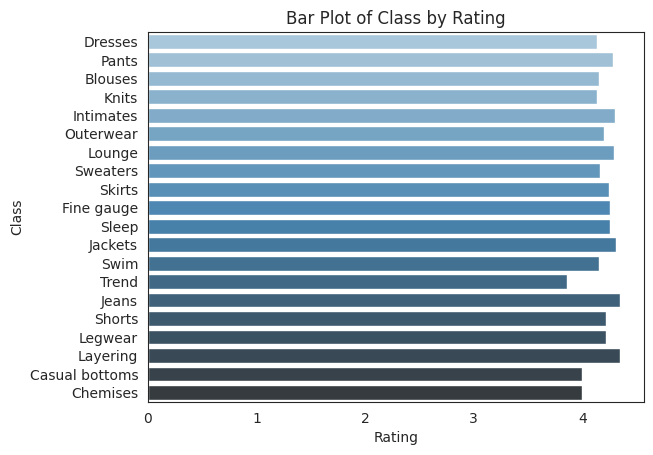

In [24]:
sns.set_style('white')
sns.barplot(x=ecom_review['Rating'], y=ecom_review['Class'], palette="Blues_d", ci=None)
plt.title("Bar Plot of Class by Rating")

plt.show()

**The layering class of clothing (dresses) receives higher ratings compared to other classes.**

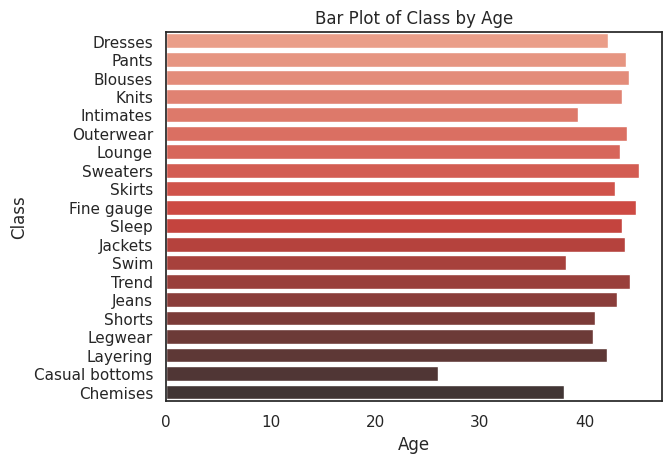

In [25]:
sns.set_theme(style="white")
sns.color_palette("flare", as_cmap=False)

ax = sns.barplot(x=ecom_review['Age'], y=ecom_review['Class'], palette="Reds_d", ci=None)
ax.set_title("Bar Plot of Class by Age")

plt.show()

**The bar plot below demonstrates that sweaters are preferred by individuals above the age of 40, while casual bottoms tend to attract those in their 20s.**

In [26]:
fig = px.box(ecom_review, y='feedback_count')

fig.update_layout(
    title='Feedback Count (Box Plot)',
    xaxis_title='Feedback Count',
    font=dict(size=17, family='Franklin Gothic'),
    template='simple_white'
)

fig.show()

**Positive Integer documenting the number of other customers who found this review positive.**

In [27]:
class_counts = ecom_review['Division'].value_counts()

fig = go.Figure(data=go.Bar(
    x=class_counts.index,
    y=class_counts.values,
    marker=dict(color='blue'),
))

fig.update_layout(
    title='Bar Plot of Division',
    xaxis_title='Division',
    yaxis_title='Count',
)

fig.show()

**Among the three divisions—General, General Petite, and Intimates—women predominantly purchase items from the General division.**

In [28]:
data = pd.crosstab(ecom_review.Division, ecom_review.Recommended)

# Converting the crosstab result to a Plotly bar chart
fig = go.Figure(data=[
    go.Bar(x=data.index, y=data[0], name='Not Recommended'),
    go.Bar(x=data.index, y=data[1], name='Recommended')
])

# Setting the layout and title
fig.update_layout(title='Cross-tabulation of Division and Recommended', xaxis_title='Division', yaxis_title='Count')

fig.show()

In [29]:


class_counts = ecom_review['Department'].value_counts()

fig = go.Figure(data=go.Bar(
    x=class_counts.index,
    y=class_counts.values,
    marker=dict(color='blue'),
))

fig.update_layout(
    title='Bar Plot of Department',
    xaxis_title='Department',
    yaxis_title='Count',
)

fig.show()

In [30]:
department_ratings = ecom_review.groupby('Department')['Rating'].sum()

fig = go.Figure(data=go.Pie(
    labels=department_ratings.index,
    values=department_ratings.values,
    textinfo='label+percent',
    hole=0.3,
    marker=dict(colors=['#FFCDD2', '#B2DFDB', '#FFD54F', '#FFA726']),
))

fig.update_layout(
    title='Pie Chart of Rating by Department',
    width=800,
    height=500,
)

fig.show()

**Piechart visualize that the Tops department has gotten the most amounts of ratings, where Trends got the low amount of ratings**

In [31]:
fig = go.Figure()

for department in ecom_review['Department'].unique():
    fig.add_trace(go.Box(
        x=ecom_review[ecom_review['Department'] == department]['Department'],
        y=ecom_review[ecom_review['Department'] == department]['Age'],
        name=department
    ))

fig.update_layout(
    title='Box Plot of Age by Department',
    xaxis_title='Department',
    yaxis_title='Age'
)

fig.show()

**We can see that all the Departments are quite balanced and have similar range not showing much variation.**

In [32]:
data = pd.crosstab(ecom_review.Department, ecom_review.Recommended)

# Converting the crosstab result to a Plotly bar chart
fig = go.Figure(data=[
    go.Bar(x=data.index, y=data[0], name='Not Recommended'),
    go.Bar(x=data.index, y=data[1], name='Recommended')
])

# Setting the layout and title
fig.update_layout(title='Cross-tabulation of Department and Recommended', xaxis_title='Age', yaxis_title='Count')

fig.show()

**NLP-based review classification for women's clothing recommendations**

In [33]:
review = ecom_review[['Title', 'Review Text', 'Recommended']].copy()

In [34]:
review.head()

,Title,Review Text,Recommended
2,Some major design flaws,I had such high hopes for this dress and reall...,0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1
4,Flattering shirt,This shirt is very flattering to all due to th...,1
5,Not for the very petite,"I love tracy reese dresses, but this one is no...",0
6,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1


In [35]:
review['Review'] = review['Title'] + ' ' + review['Review Text']
review = review.drop(labels=['Title', 'Review Text'], axis=1)

In [36]:
review.head()

,Recommended,Review
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...
5,0,Not for the very petite I love tracy reese dre...
6,1,Cagrcoal shimmer fun I aded this in my basket ...


**Word Cloud**

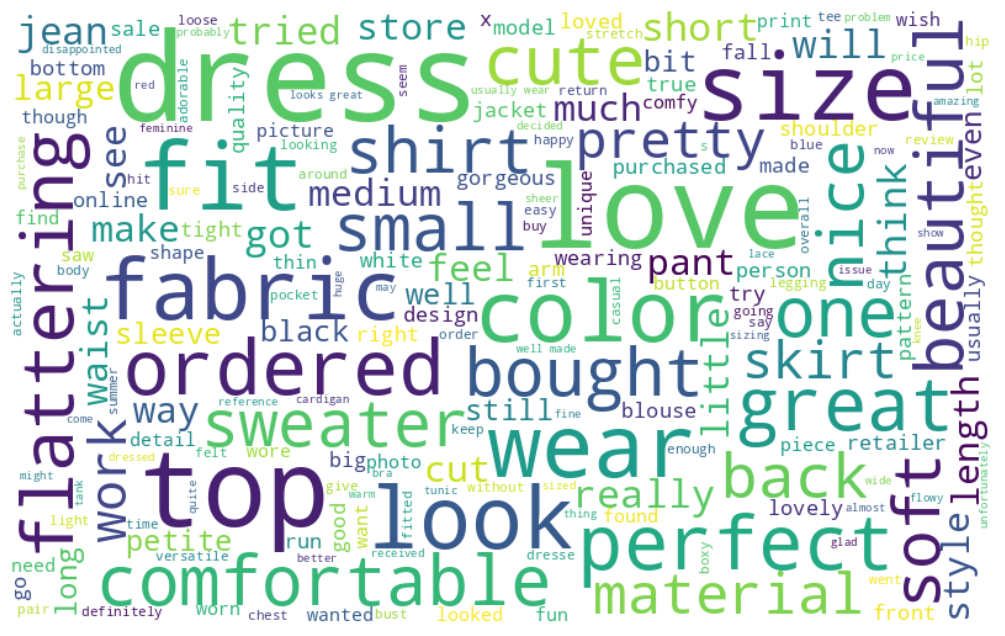

In [37]:
!pip install wordcloud
#Visualizing the Keywords
all_words = " ".join([sentence for sentence in review["Review"]]) #Combines all the sentences into a single string

from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white', width = 800, height = 500, random_state = 42, max_font_size = 100).generate(all_words)

#Plotting the graph
plt.figure(figsize = (15, 8))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

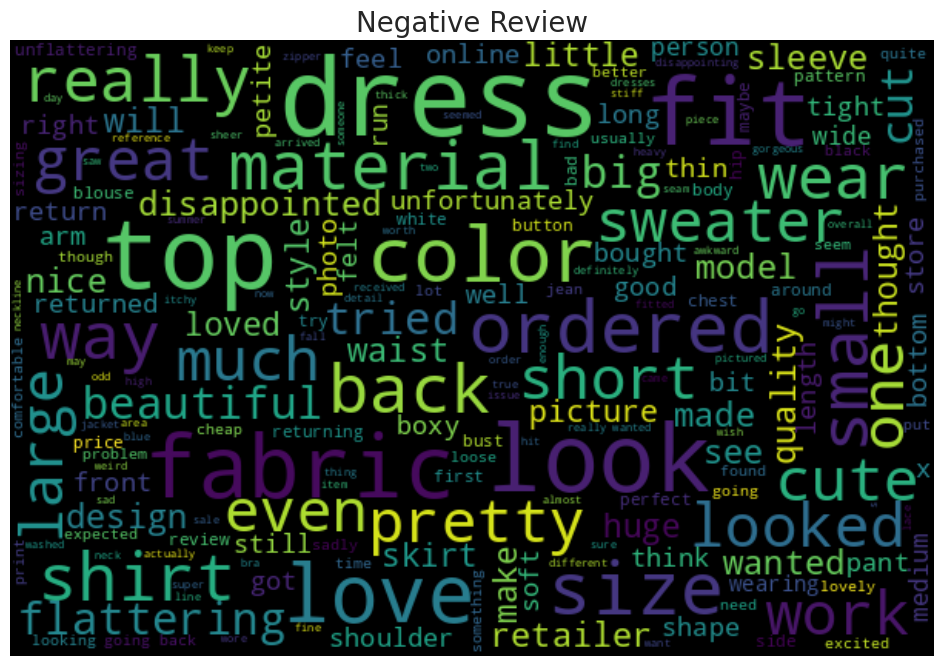

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_words = " ".join([sentence for sentence in review["Review"][review["Recommended"]==0]])

wordcloud = WordCloud(background_color='black', width=600, height=400, random_state=42, max_font_size=70).generate(all_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Negative Review", fontsize=20)
plt.axis("off")
plt.show()


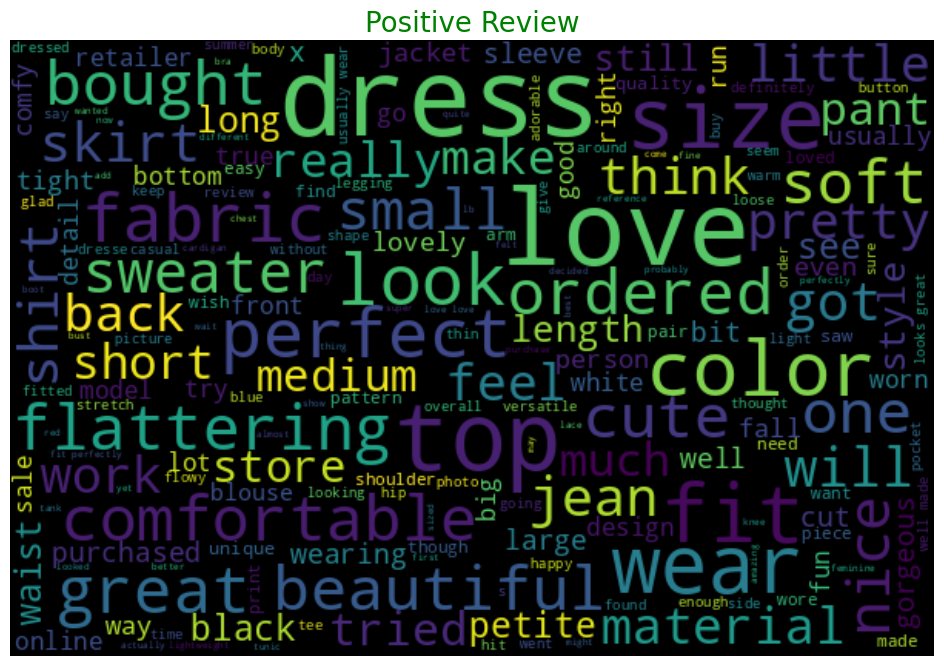

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_words = " ".join([sentence for sentence in review["Review"][review["Recommended"]==1]])

wordcloud = WordCloud(background_color='black', width=600, height=400, random_state=42, max_font_size=70).generate(all_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title(label="Positive Review", fontsize=20, color="green")
plt.axis("off")
plt.show()


In [40]:
review.Review.isnull().sum()

0

In [41]:
review.shape

(19661, 2)

In [42]:
# get all of strings from sentences
def get_all_str(sentences):
    sentence = ''
    for words in sentences:
        sentence += words
    sentence = sentence.lower()
    return sentence

# get string from list
def get_str(lst):
    sentence = ''
    for char in lst:
        sentence += char+' '
    sentence = sentence.lower()
    return sentence

# get word from text
def get_word(text):
    result = nltk.RegexpTokenizer(r'\w+').tokenize(text.lower())
    return result

# remove stopwords from list
def remove_stopword(lst):
    stoplist = stopwords.words('english')
    txt = ''
    for idx in range(len(lst)):
        txt += lst[idx]
        txt += '\n'
    cleanwordlist = [word for word in txt.split() if word not in stoplist]
#     print(stoplist)
    return cleanwordlist

# lemmatize
def lemmatization(words):
    lemm = WordNetLemmatizer()
    tokens = [lemm.lemmatize(word) for word in words]
    return tokens

In [43]:
# preprocess: remove stopwords-> lemmatize
def preprocess(column):
    all_str = get_all_str(column)
    words = get_word(all_str)
    after_removing = remove_stopword(words)
    lemmatize = lemmatization(after_removing)
    return lemmatize

review['Review'] = review['Review'].apply(preprocess)

In [46]:
x = review["Review"]
y= review["Recommended"]

In [47]:
x

2        [major, design, flaw, high, hope, dress, reall...
3        [favorite, buy, love, love, love, jumpsuit, fu...
4        [flattering, shirt, shirt, flattering, due, ad...
5        [petite, love, tracy, reese, dress, one, petit...
6        [cagrcoal, shimmer, fun, aded, basket, hte, la...
                               ...                        
23481    [great, dress, many, occasion, happy, snag, dr...
23482    [wish, made, cotton, reminds, maternity, cloth...
23483    [cute, see, fit, well, top, see, never, would,...
23484    [cute, dress, perfect, summer, party, bought, ...
23485    [please, make, like, one, dress, lovely, plati...
Name: Review, Length: 19661, dtype: object

In [48]:
#tokenization
from keras.preprocessing.text import Tokenizer
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(x)
xtokens= tokenizer.texts_to_sequences(x)

In [49]:
sentences = tokenizer.sequences_to_texts(xtokens)

# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
xvec = vectorizer.fit_transform(sentences)

In [50]:
#train_test split
x_train, x_test, y_train, y_test = train_test_split(xvec, y, test_size=0.2, stratify=y,random_state=42)

In [51]:
accuracy_list = []
f1_list = []
roc_auc_list = []

In [52]:
def result(model):

    #fit on data
    model.fit(x_train, y_train)

    #prediction
    pred = model.predict(x_test)

    #performance of model
    print("Classification Report: \n", classification_report(y_test, pred))
    print("-" * 100)
    print()

    #accuracy of model
    acc = accuracy_score(y_test, pred)
    accuracy_list.append(acc)
    print("Accuracy Score: ", acc)
    print("-" * 100)
    print()

    #f1-score of model
    f1 = f1_score(y_test, pred)
    f1_list.append(f1)
    print("F1 Score: ", f1)
    print("-" * 100)
    print()

    #roc-auc curve of model
    fpr,tpr,threshold = roc_curve(y_test,pred)
    auc_value = auc(fpr,tpr)
    rocauc_score = roc_auc_score(y_test, pred)
    roc_auc_list.append(rocauc_score)
    plt.figure(figsize=(5,5),dpi=100)
    print("ROC-AUC Score: ", f1)
    print("-" * 100)
    print()
    plt.plot(fpr,tpr,linestyle='-',label = "(auc_value = %0.3f)" % auc_value)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print()

    #confusion matrix for model
    print("Confusion Matrix: ")
    plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='g');
    plt.title('Confusion Matrix', fontsize=20)

Logestic Regression Model
------------------
Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.59      0.68       715
           1       0.91      0.97      0.94      3218

    accuracy                           0.90      3933
   macro avg       0.86      0.78      0.81      3933
weighted avg       0.89      0.90      0.89      3933

----------------------------------------------------------------------------------------------------

Accuracy Score:  0.8993135011441648
----------------------------------------------------------------------------------------------------

F1 Score:  0.9402895054282268
----------------------------------------------------------------------------------------------------

ROC-AUC Score:  0.9402895054282268
----------------------------------------------------------------------------------------------------



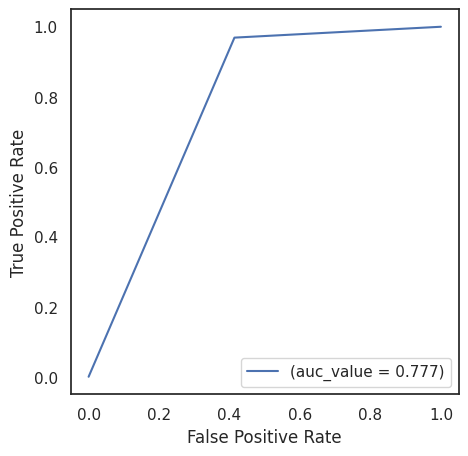


Confusion Matrix: 


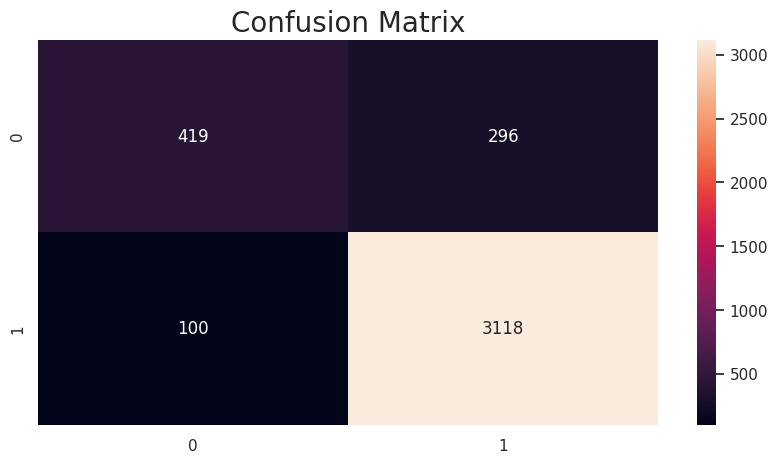

In [53]:
from sklearn.linear_model import LogisticRegression
logreg_count = LogisticRegression()
print("Logestic Regression Model")
print ("------------------")
result(logreg_count)

Random Forest Classifier
------------------
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.29      0.43       715
           1       0.86      0.99      0.92      3218

    accuracy                           0.86      3933
   macro avg       0.87      0.64      0.68      3933
weighted avg       0.86      0.86      0.83      3933

----------------------------------------------------------------------------------------------------

Accuracy Score:  0.863208746503941
----------------------------------------------------------------------------------------------------

F1 Score:  0.9222093695777906
----------------------------------------------------------------------------------------------------

ROC-AUC Score:  0.9222093695777906
----------------------------------------------------------------------------------------------------



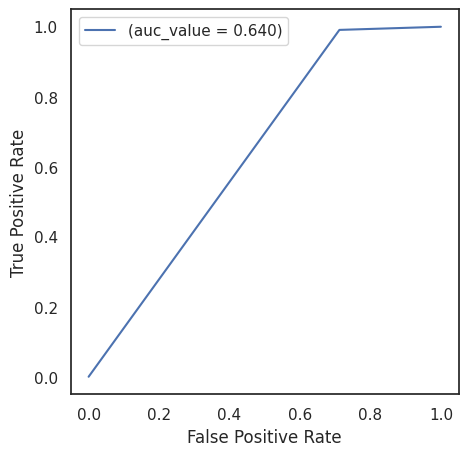


Confusion Matrix: 


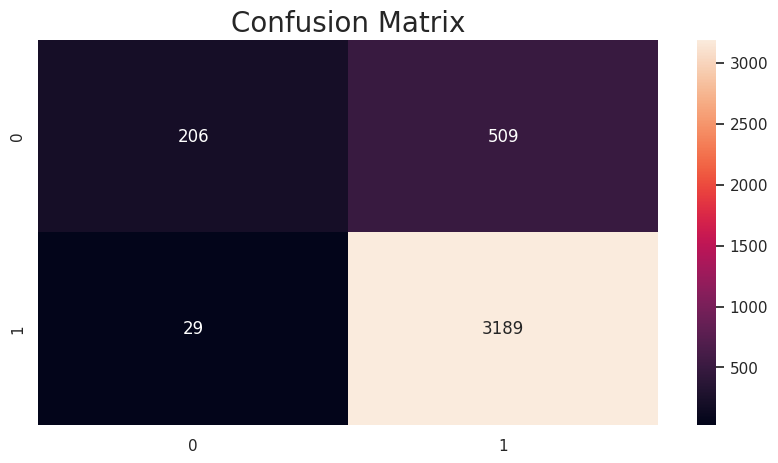

In [54]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion = 'entropy', random_state = 42)
print("Random Forest Classifier")
print ("------------------")
result(rf)

SVM Model
------------------
Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.66      0.71       715
           1       0.93      0.96      0.94      3218

    accuracy                           0.90      3933
   macro avg       0.85      0.81      0.83      3933
weighted avg       0.90      0.90      0.90      3933

----------------------------------------------------------------------------------------------------

Accuracy Score:  0.9036359013475719
----------------------------------------------------------------------------------------------------

F1 Score:  0.9420223344041608
----------------------------------------------------------------------------------------------------

ROC-AUC Score:  0.9420223344041608
----------------------------------------------------------------------------------------------------



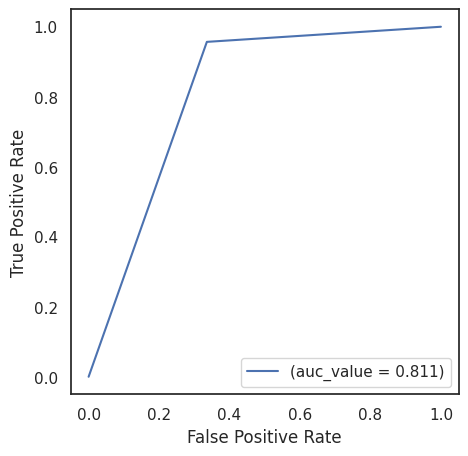


Confusion Matrix: 


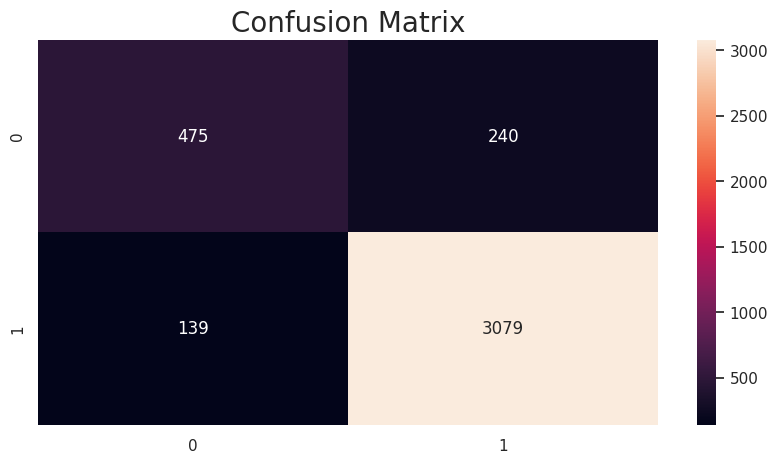

In [55]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
print("SVM Model")
print ("------------------")
result(svclassifier)

K Nearest Neighbors Model
------------------
Classification Report: 
               precision    recall  f1-score   support

           0       0.72      0.39      0.51       715
           1       0.88      0.97      0.92      3218

    accuracy                           0.86      3933
   macro avg       0.80      0.68      0.71      3933
weighted avg       0.85      0.86      0.84      3933

----------------------------------------------------------------------------------------------------

Accuracy Score:  0.8616831934909738
----------------------------------------------------------------------------------------------------

F1 Score:  0.9195028114826873
----------------------------------------------------------------------------------------------------

ROC-AUC Score:  0.9195028114826873
----------------------------------------------------------------------------------------------------



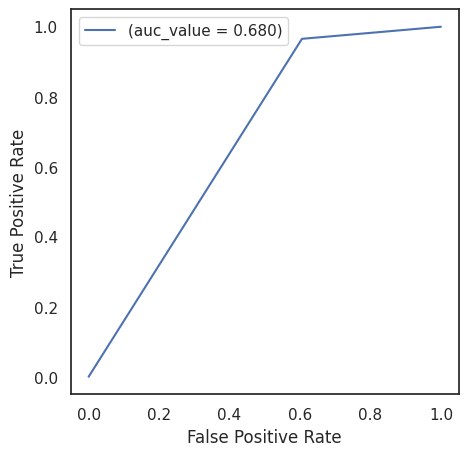


Confusion Matrix: 


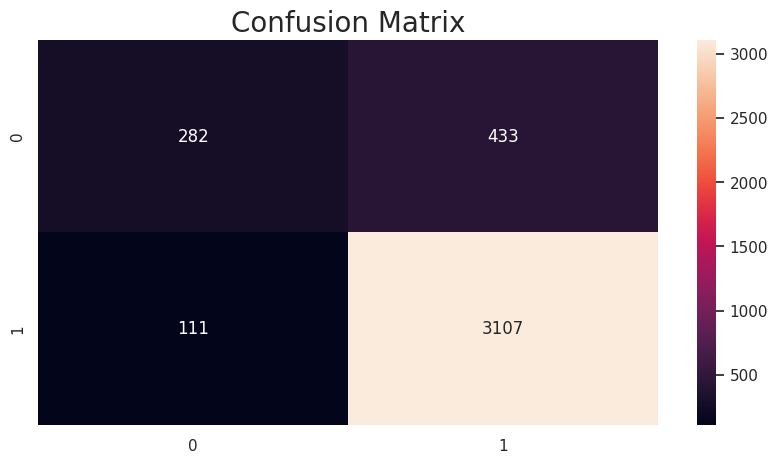

In [56]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=5)
print("K Nearest Neighbors Model")
print ("------------------")
result(knn)

Naive Bayes Model
------------------
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.10      0.18       715
           1       0.83      1.00      0.91      3218

    accuracy                           0.83      3933
   macro avg       0.88      0.55      0.54      3933
weighted avg       0.85      0.83      0.78      3933

----------------------------------------------------------------------------------------------------

Accuracy Score:  0.8347317569285533
----------------------------------------------------------------------------------------------------

F1 Score:  0.9081142210913205
----------------------------------------------------------------------------------------------------

ROC-AUC Score:  0.9081142210913205
----------------------------------------------------------------------------------------------------



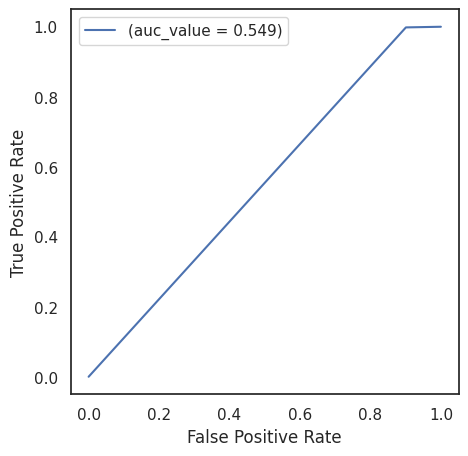


Confusion Matrix: 


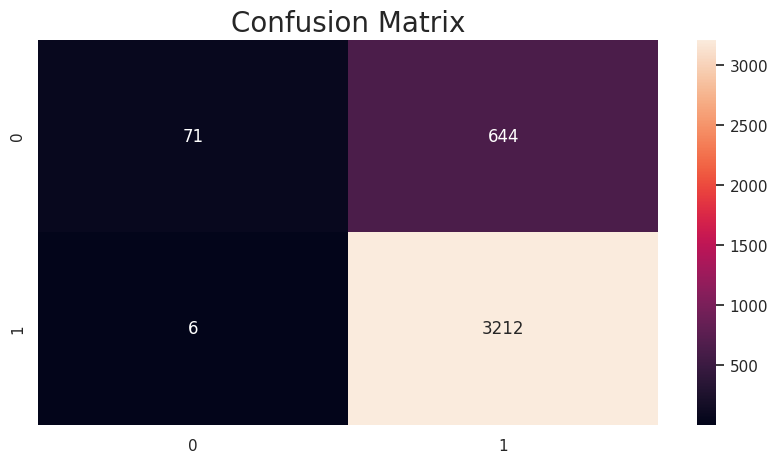

In [57]:
from sklearn.naive_bayes import MultinomialNB
NBayes= MultinomialNB()
print("Naive Bayes Model")
print("------------------")
result(NBayes)

In [58]:
# New text data
unseen_text =["Sadly, i will have to return this",'Not what i wanted', 'I love the dress','Disappointed with this']
# text transform
unseen_text_tokens = tokenizer.texts_to_sequences(unseen_text)
unseen_text_sentences = tokenizer.sequences_to_texts(unseen_text_tokens)
unseen_text_vec = vectorizer.transform(unseen_text_sentences)

In [59]:
models = [
    ("Logistic Regression", logreg_count),
    ("Random Forest", rf),
    ("SVM", svclassifier),
    ("K-Nearest Neighbors", knn),
    ("Naive Bayes", NBayes)
]

In [68]:
for model_name, model in models:
    # Predict on unseen data
    predictions = model.predict(unseen_text_vec)

    # Print the predictions
    print("Unseen Text :\n")
    print("Sadly, i will have to return this'  'Not what i wanted'  'I love the dress'  'Disappointed with this'")
    print()
    print(f"{model_name} predictions:")
    print(predictions)
    print()
    print("0 - Negative review (Non-Recommended) \n1 - Positive review (Recommended)")
    print("--------------------------------------------------------------------------")

Unseen Text :

Sadly, i will have to return this'  'Not what i wanted'  'I love the dress'  'Disappointed with this'

Logistic Regression predictions:
[0 0 1 0]

0 - Negative review (Non-Recommended) 
1 - Positive review (Recommended)
--------------------------------------------------------------------------
Unseen Text :

Sadly, i will have to return this'  'Not what i wanted'  'I love the dress'  'Disappointed with this'

Random Forest predictions:
[0 1 1 0]

0 - Negative review (Non-Recommended) 
1 - Positive review (Recommended)
--------------------------------------------------------------------------
Unseen Text :

Sadly, i will have to return this'  'Not what i wanted'  'I love the dress'  'Disappointed with this'

SVM predictions:
[0 0 1 0]

0 - Negative review (Non-Recommended) 
1 - Positive review (Recommended)
--------------------------------------------------------------------------
Unseen Text :

Sadly, i will have to return this'  'Not what i wanted'  'I love the dress'  

**After comparing multiple models for sentiment analysis of women's clothing e-commerce reviews, SVM performed the best, followed by Logistic Regression. SVM's ability to find the optimal hyperplane and handle high-dimensional features contributed to its superior accuracy in classifying sentiments. Logistic Regression also exhibited reliable performance. Other models, including Random Forest Classifier, KNN, and Naive Bayes, were not as accurate. Employing SVM and Logistic Regression can enhance recommendation systems by providing more accurate assessments of customer sentiment, ultimately improving customer satisfaction in the women's clothing e-commerce domain.**